# Tutorial on How to Implement a 2048 Environment

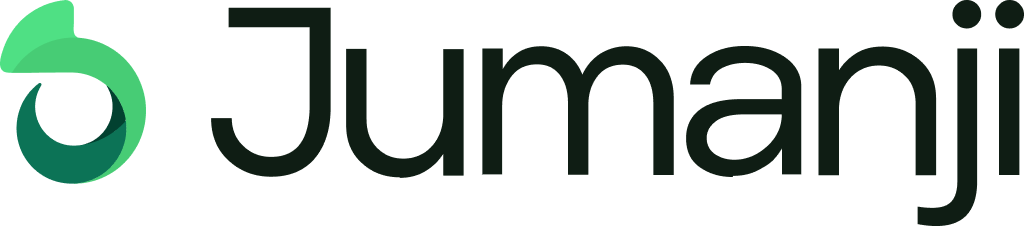

# Introduction 
This tutorial will guide you through the implementation of an environment in Jumanji. We will take the example of **2048**. 

We will follow the following steps:
- [x] Implement types
- [x] Environment dynamics: step and reset
- [x] Run a random agent on the environment
- [x] Check the rendering of the environment

## Installing packages
We start by installing Jumanji

In [ ]:
%%capture
! pip install jumanji
! pip install Pillow==9.0.0


## 1. Types
The types will define the data types used to represent the state and observations of the environment.
- `State`: What data/variables you need to store in your environment to easily write the environment methods.
- `Observation`: What meaningful information you should provide to the agent. 

### Import the necessary modules
`Array` and `Numeric` are modules within the Chex library that provide functionality for working with JAX arrays and numerical computations.

In [ ]:
from chex import Array, Numeric, PRNGKey
from typing_extensions import TypeAlias
#"State" and "Observation" are implemented as NamedTuple.
from typing import NamedTuple

Board: TypeAlias = Array

To update the environment state, we forecast that we will need to store the board, a random key for any stochastic operation (sampling a new target location when reached), action mask that indicates which actions are legal or valid to take in a given state of the environment, a step count to terminate the episode when the horizon is reached and a score to count the cummulative reward in order to showcase it in the rendering.

In [ ]:
class State(NamedTuple):
    board: Board
    step_count: Numeric
    action_mask: Array
    key: PRNGKey
    score: Numeric

class Observation(NamedTuple):
    board: Board
    action_mask: Array

## Util functions
1. Generate a random cell with value 2 or 4.
2. Generate an inital board.
3. Shift and merge the cells of the game to the 4 directions [Up, Right, Down, Left]


In [ ]:
%%capture
import jax
import jax.numpy as jnp
from typing import Tuple

### Add random cell
This function adds a random cell to a given game board. It first selects an empty position on the board at random and assigns a value of 2 or 4 to that position. The function takes in two arguments: the current game board and a key for the random number generator. It returns the updated game board with the new random cell added.

In [ ]:
# First approach
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    
    # Generate a new key
    key, subkey = jax.random.split(key)

    # Select position of the new random cell
    zero_indices = jnp.argwhere(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(zero_indices))
    )

    # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[tuple(zero_indices[tile_idx])].set(cell_value)

    return board

**Why we have `board=board.at[position].set(cell_value)` instead of `board[position]=cell_value`?**

In JAX, arrays are immutable, which means that you cannot modify the values of an existing array. Instead, you need to create a new array with the modified values. 

In [ ]:
# Test add_random_cell
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(0)
board=add_random_cell(board, key)
print(board)

In [ ]:
# Jitted method
add_random_cell_jit = jax.jit(add_random_cell)
board = add_random_cell_jit(board, key)
print(board)

**What is the reason for jitted functions not accepting non-static variables?**

Jitted functions may not accept non-static variables, such as arrays, because the size of the variable is not known at compile time. This can make it difficult for the compiler to generate efficient code for accessing and manipulating the variable. Dynamic allocation of variables at runtime means their size is only determined at runtime, which is why jitted functions may not be able to handle non-static variables effectively.

**Idea to solve the non-static array**
1. Flatten the matrix of the board (It will be easy to deal with 1D array than 2D when it comes to choose random position).

2. Since we can't use `argwhere`, we change the matrix values to be boolean (`True` if the cell is empty and `False` if not) and we use random choice, but we add probabilities associated to each cell.

3. After getting the random position of the new cell in the 1D array, we translate it to be for the 2D one.



In [ ]:
# Solution
def add_random_cell(board: Board, key: PRNGKey) -> Board:
    # Generate a new key
    key, subkey = jax.random.split(key)

    # Select position of the new random cell
    empty_flatten_board = jnp.ravel(board == 0)
    tile_idx = jax.random.choice(
        key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
    )
    # Convert the selected tile's location in the flattened array to its position on the board.
    board_size=board.shape[0]
    position = jnp.divmod(tile_idx, board_size)

    # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
    cell_value = jax.random.choice(
        subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
    )
    board = board.at[position].set(cell_value)

    return board

In [ ]:
# Test add_random_cell
board=jnp.array(
    [
        [ 2,  2,  0,  0],
        [ 4,  8, 16,  0],
        [16,  0, 32,  0],
        [32, 64,  0, 64]
    ]
)
key=jax.random.PRNGKey(5)
add_random_cell_jit = jax.jit(add_random_cell)
board = add_random_cell_jit(board, key)
print(board)

### Generate the initial board
This function generates an initial game board for an environment. The board is initially empty, with a specified size. The function then selects a random cell on the board and fills it with a value of 2 or 4. The function takes in two arguments, which are the board size and a key for the random number generator. It returns the generated game board as the output.

In [ ]:
def generate_board(board_size:int, key: PRNGKey) -> Board:
    # Create empty board
    board = jnp.zeros((board_size, board_size), dtype=jnp.int32)

    # Fill one random cell with a value of 2 or 4
    board = add_random_cell(board, key)

    return board

In [ ]:
key=jax.random.PRNGKey(0)
board=generate_board(4, key)
print(board)

### Board Movements and Element Merging Strategies for the 2048 Game
**1. Shift a column**

A straightforward approach to shifting all non-zero elements of an array to the left is to maintain their order while filling the remaining positions with zeros.

**Steps**
  
  a. Shift nonzero element from index i to index j and increment j. For example, in the case of this column [2, 0, 2, 0], the first loop condition will be invoked when `i` equals 0 and 2, and it will return successively ([2, 0, 2, 0], `j` = 1) and ([2, 2, 2, 0], `j` = 2).
  
  b. Fill the remaining elements of the column with zeros. For example: if the initial column is [2, 0, 2, 0] then this method will be invoked when `j`    equals to 2: [2, 2, 2, 0]-> [2, 2, 0, 0] and 3: [2, 2, 0, 0]->[2, 2, 0, 0].

In [ ]:
def shift_up(col: Array) -> Array:
    # Initialize a pointer to keep track of the next position to insert a non-zero element
    j = 0

    # Iterate over the array and move all non-zero elements to the left
    for i in range(len(col)):
        if col[i] != 0:
            col= col.at[j].set(col[i])
            j += 1

    # Fill the remaining positions with zeros
    while j< len(col):
        col=col.at[j].set(0)
        j+=1
    return col

In [ ]:
board_col=jnp.array([0, 2, 0, 2])
updated_col=shift_up(board_col)
print(updated_col)

In [ ]:
shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print(updated_col)

**Why if statement and while loop don't work in the case of jitted functions?**

Compared to regular Python functions, the jitted functions have certain limitations. For instance, Jitted functions cannot handle certain types of dynamic operations, such as executing arbitrary Python code or using variable-sized data structures. As a result, Jitted functions may not be able to use certain control flow statements, such as if statements and while loops, in the same way as regular Python functions.


**Solution**

Using `jax.lax`: it is a sub-module of the JAX library, which provides low-level operations for building high-performance numerical computations. jax.lax provides a set of composable functions for performing low-level linear algebra and other numerical operations, and is designed to be efficient, composable, and portable across different hardware platforms.

*if statement* -> `jax.lax.cond(condition, true_fun, false_fun, vars)`

*while loop* -> `jax.lax.while_loop(cond_fun, body_fun, init_val)[source]`

*for loop* -> `jax.lax.scan(f, init, xs)`

In [ ]:
def shift_nonzero_element(carry: Tuple) -> Tuple[Array, int]:
    col, j, i = carry
    col = col.at[j].set(col[i])
    j += 1
    return col, j


def shift_column_elements_up(carry: Tuple, i: int) -> Tuple[Array, None]:
    col, j = carry
    col, j = jax.lax.cond(
        col[i] != 0,
        shift_nonzero_element,
        lambda col_j_i: col_j_i[:2],
        (col, j, i),
    )
    return (col, j), None


def fill_with_zero(carry: Tuple[Array, int]) -> Tuple[Array, int]:
    col, j = carry
    col = col.at[j].set(0)
    j += 1
    return col, j


def shift_up(col: Array) -> Array:
    j = 0
    (col, j), _ = jax.lax.scan(  # In example: [2, 0, 2, 0] -> [2, 2, 2, 0]
        f=shift_column_elements_up, init=(col, j), xs=jnp.arange(len(col))
    )
    col, j = jax.lax.while_loop(  # In example: [2, 2, 2, 0] -> [2, 2, 0, 0]
        lambda col_j: col_j[1] < len(col_j[0]),
        fill_with_zero,
        (col, j),
    )
    return col

In [ ]:
shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print(updated_col)

**2. Merge elements**

Combine the adjacent equal elements of a column to the left in accordance with the rules of the 2048 game. As an example, `[0, 0, 2, 2]` can be merged to produce `[0, 0, 4, 0]`.

In [ ]:
def merge_elements(carry: Tuple) -> Tuple[Array, float]:
    col, reward, i = carry
    new_col_i = 2*col[i]
    col = col.at[i].set(new_col_i)
    col = col.at[i + 1].set(0)
    reward += new_col_i
    return col, reward


def merge_equal_elements(
    carry: Tuple[Array, float], i: int
) -> Tuple[Tuple[Array, float], None]:
    col, reward = carry
    col, reward = jax.lax.cond(
        ((col[i] != 0) & (col[i] == col[i + 1])),
        merge_elements,
        lambda col_reward_i: col_reward_i[:2],
        (col, reward, i),
    )
    return (col, reward), None

@jax.jit
def merge_col(col: Array) -> Tuple[Array, float]:
    reward = 0.0
    elements_indices = jnp.arange(len(col) - 1)
    (col, reward), _ = jax.lax.scan(
        f=merge_equal_elements, init=(col, reward), xs=elements_indices
    )
    return col, reward

In [ ]:
print("Initial column: ",board_col)

shift_up_jit = jax.jit(shift_up)
updated_col = shift_up_jit(board_col)
print("After shifting the elements: ",updated_col)

updated_col = merge_col(updated_col)

print("After merging equal elements: ",updated_col[0], "with a reward equals: ",updated_col[1])

**3. Different movements**


In [ ]:
def move_up_col(carry: Tuple[Board, float], c: int)-> Tuple[Tuple[Board, float], None]:
    board, additional_reward = carry
    col = board[:, c]
    col = shift_up(col)  # In example: [4, 4, 2, 2] -> [4, 4, 2, 2]
    col, reward = merge_col(col)  # In example: [4, 4, 2, 2] -> [8, 0, 4, 0]
    col = shift_up(col)  # In example: [8, 0, 4, 0] -> [8, 4, 0, 0]
    additional_reward += reward
    return (board.at[:, c].set(col), additional_reward), None

@jax.jit
def move_up(board: Board) -> Tuple[Board, float]:
    """Move up."""
    additional_reward = 0.0
    col_indices = jnp.arange(board.shape[0])  # Board of size 4 -> [0, 1, 2, 3]
    (board, additional_reward), _ = jax.lax.scan(
        f=move_up_col,
        init=(board, additional_reward),
        xs=col_indices,
    )
    return board, additional_reward


def move_down(board: Board) -> Tuple[Board, float]:
    """Move down."""
    board, additional_reward = move_up(
        board=jnp.flip(board, 0)
    )
    return jnp.flip(board, 0), additional_reward


def move_left(board: Board) -> Tuple[Board, float]:
    """Move left."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=-1)
    )
    return jnp.rot90(board, k=1), additional_reward


def move_right(board: Board) -> Tuple[Board, float]:
    """Move right."""
    board, additional_reward = move_up(
        board=jnp.rot90(board, k=1)
    )
    return jnp.rot90(board, k=-1), additional_reward

In [ ]:
board = jnp.array([
    [4, 2, 2, 0],
    [4, 8, 2, 4],
    [4, 8, 2, 4],
    [4, 8, 0, 0]
  ])
board, reward = move_up(board)
print("After moving up: \n",board,"\n Reward: ",reward )

### Import the necessary modules
In an environment, the following concepts are typically defined:
- TimeStep: A timestep represents a single step or moment in the environment, including the current state, reward, discount, and other relevant information.
- Restart: A restart occurs when the environment is reset to its initial state, typically at the start of a new episode.
- Termination: A termination occurs when an episode ends, either because the agent has reached a terminal state or because a maximum number of timesteps has been reached.
- Transition: A transition refers to the process of moving from one state to another state, typically as a result of the agent taking an action.

In [ ]:
from typing import Optional, Sequence, Tuple

import jax
import jax.numpy as jnp
from chex import Array, PRNGKey

#"spec" is a set of parameters that define its behavior and enable reproducible instances for testing.
from jumanji import specs
from jumanji.env import Environment

from jumanji.types import TimeStep, restart, termination, transition

import matplotlib.pyplot as plt
import chex
import functools
%matplotlib inline
from env_viewer import Game2048Viewer

## Env implementation
Now you can implement the environment dynamics using the variables you defined in the `State`. During this process, you may need to iterate going back and forth between implementing the `step` and `reset` functions and changing the `State` to include anything you may have forgotten that is needed for the environment dynamics.

Need to implement the following methods:
- `observation_spec()`: defines the observation spec.
- `action_spec()`: defines the action spec.
- `reset(key)`: the environment reset behavior. This method generates a new instance/problem/initial state. Also returns a `TimeStep` that contains observation, reward, etc, things observed by the agent.
- `step(state, action)`: the environment step behavior. This method generates a new environment state given a current state and an action taken by the agent. Also returns a `TimeStep` that contains observation, reward, etc, things observed by the agent.

In [ ]:
class Game2048(Environment[State]):
  
    def __init__(
        self, board_size: int = 4, env_viewer: Optional[Game2048Viewer] = None
    ) -> None:
        self.board_size = board_size

        # Create viewer used for rendering
        self._env_viewer = env_viewer or Game2048Viewer("2048", board_size)

    def __repr__(self) -> str:
        """String representation of the environment."""
        return f"2048 Game(board_size={self.board_size})"

    def observation_spec(self) -> specs.Spec:
        """Specifications of the observation of the `Game2048` environment."""
        return specs.Spec(
            Observation,
            "ObservationSpec",
            board=specs.Array(
                shape=(self.board_size, self.board_size),
                dtype=jnp.int32,
                name="board",
            ),
            action_mask=specs.BoundedArray(
                shape=(4,),
                dtype=bool,
                minimum=False,
                maximum=True,
                name="action_mask",
            ),
        )

    def action_spec(self) -> specs.DiscreteArray:
        """Returns the action spec.

        4 actions: [0, 1, 2, 3] -> [Up, Right, Down, Left].

        Returns:
            action_spec: `DiscreteArray` spec object.
        """
        return specs.DiscreteArray(4, name="action")

    def reset(self, key: PRNGKey) -> Tuple[State, TimeStep[Observation]]:
        """Resets the environment."""

        key, board_key = jax.random.split(key)
        board = self._generate_board(board_key)
        action_mask = self._get_action_mask(board)

        obs = Observation(board=board, action_mask=action_mask)

        timestep = restart(observation=obs)

        state = State(
            board=board,
            step_count=jnp.int32(0),
            action_mask=action_mask,
            key=key,
            score=jnp.array(0, float),
        )

        return state, timestep

    def step(self, state: State, action) -> Tuple[State, TimeStep[Observation]]:
        """Updates the environment state after the agent takes an action."""
  
        # Take the action in the environment: Up, Right, Down, Left.
        updated_board, additional_reward = jax.lax.switch(
            action,
            [move_up, move_right, move_down, move_left],
            state.board,
        )

        # Generate action mask to keep in the state for the next step and
        # to provide to the agent in the observation.
        action_mask = self._get_action_mask(board=updated_board)

        # Check if the episode terminates (i.e. there are no legal actions).
        done = ~jnp.any(action_mask)

        # Generate new key.
        random_cell_key, new_state_key = jax.random.split(state.key)

        # Update the state of the board by adding a new random cell.
        updated_board = jax.lax.cond(
            done,
            lambda board, pkey: board,
            self._add_random_cell,
            updated_board,
            random_cell_key,
        )

        # Build the state.
        state = State(
            board=updated_board,
            action_mask=action_mask,
            step_count=state.step_count + 1,
            key=new_state_key,
            score=state.score + additional_reward.astype(float),
        )

        # Generate the observation from the environment state.
        observation = Observation(
            board=updated_board,
            action_mask=action_mask,
        )

        # Return either a MID or a LAST timestep depending on done.
        timestep = jax.lax.cond(
            done,
            termination,
            transition,
            additional_reward,
            observation,
        )

        return state, timestep

    def _generate_board(self, key: PRNGKey) -> Board:
        """Generates an initial board for the environment."""

        # Create empty board
        board = jnp.zeros((self.board_size, self.board_size), dtype=jnp.int32)

        # Fill one random cell with a value of 2 or 4
        board = self._add_random_cell(board, key)

        return board

    def _add_random_cell(self, board: Board, key: PRNGKey) -> Board:
        """Adds a new random cell to the board."""
        key, subkey = jax.random.split(key)

        # Select position of the new random cell
        empty_flatten_board = jnp.ravel(board == 0)
        tile_idx = jax.random.choice(
            key, jnp.arange(len(empty_flatten_board)), p=empty_flatten_board
        )
        # Convert the selected tile's location in the flattened array to its position on the board.
        position = jnp.divmod(tile_idx, self.board_size)

        # Choose the value of the new cell: 2 with probability 90% or 4 with probability of 10%
        cell_value = jax.random.choice(
            subkey, jnp.array([2, 4]), p=jnp.array([0.9, 0.1])
        )
        board = board.at[position].set(cell_value)

        return board

    def _get_action_mask(self, board: Board) -> Array:
        """Generates a binary mask indicating which actions are valid.

        If the movement in that direction leaves the board unchanged, the action is
        considered illegal.

        Args:
            board: current board of the environment.

        Returns:
            action_mask: action mask for the current state of the environment.
        """
        action_mask = jnp.array(
            [
                jnp.any(move_up(board)[0] != board),
                jnp.any(move_right(board)[0] != board),
                jnp.any(move_down(board)[0] != board),
                jnp.any(move_left(board)[0] != board),
            ],
        )
        return action_mask

    def render(self, state: State, save: bool = True, path: str = "./2048.png") -> None:
        """Renders the current state of the game board."""
        self._env_viewer.render(state=state, save=save, path=path)

    def animate(
        self,
        states: Sequence[State],
        interval: int = 400,
        blit: bool = False,
        save: bool = True,
        path: str = "./2048.gif",
    ):
        """Creates an animated gif of the 2048 game board based on the sequence of game states."""

        return self._env_viewer.animate(
            states=states, interval=interval, blit=blit, save=save, path=path
        )

### Random Agent

- Debug with random actions to check that your environment works properly and follows the env interface.

- Visualize a random policy acting on your problem.


In [ ]:
def random_rollout(game2048: Game2048, key: chex.PRNGKey) -> chex.Numeric:
    def body_fun(
            carry: Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric],
    ) -> Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric]:
        state, timestep, key, return_ = carry
        action_key, key = jax.random.split(key)
        action = jax.random.choice(action_key, jnp.arange(4), p=state.action_mask.flatten())
        state, timestep = game2048.step(state, action)
        return_ += timestep.reward
        return state, timestep, key, return_

    state, timestep = game2048.reset(key)
    state, timestep, key, return_ = jax.lax.while_loop(
        cond_fun=lambda carry: ~carry[1].last(),
        body_fun=body_fun,
        init_val=(state, timestep, key, jnp.float32(0)),
    )
    return return_

random_rollout_jit = jax.jit(functools.partial(random_rollout, Game2048(4)))

In [ ]:
keys = jax.random.split(jax.random.PRNGKey(0), 1000)
returns = jnp.array([random_rollout_jit(key) for key in keys])
print(f"Average return: {returns.mean():.1f} +/- {returns.std():.1f}")
plt.hist(returns)
plt.title("Returns on a 4x4 game2048")
plt.xlabel("Return");

**Non jitting vs Jitting the environment**

In [ ]:
# Jitted methods
%%timeit
random_rollout_jit(keys[0])

In [ ]:
# Non jitted method
%%timeit
random_rollout(Game2048(4), keys[0])

## Rendering
Let's see how the agent played 2048 to receive over 4000 score for the random key 135.

In [ ]:
def random_rollout(game2048: Game2048, key: chex.PRNGKey) -> chex.Numeric:
    def body_fun(
            carry: Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric],
    ) -> Tuple[State, TimeStep, chex.PRNGKey, chex.Numeric]:
        state, timestep, key, return_ = carry
        action_key, key = jax.random.split(key)
        action = jax.random.choice(action_key, jnp.arange(4), p=state.action_mask.flatten())
        state, timestep = game2048.step(state, action)
        return_ += timestep.reward
        return state, timestep, key, return_

    state, timestep = game2048.reset(key)
    states=[]
    states.append(state)
    return_=jnp.float32(0)
    while not timestep.last():
        state, timestep, key, return_=body_fun((state, timestep, key, return_))
        states.append(state)
    return states, return_

game2048=Game2048(4)
states, return_=random_rollout(game2048, keys[0]) 
game2048.animate(states=states, interval=400, blit=False)